In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import early_stopping

In [2]:
train = pd.read_csv('train_df.csv')
test = pd.read_csv('test_df.csv')

#check unique values later 
train['body_system_2'] = train['body_system_2'].replace('Undefined Diagnoses', 'Undefined diagnoses')
test['body_system_2'] = test['body_system_2'].replace('Undefined Diagnoses', 'Undefined diagnoses')

In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51359 entries, 0 to 51358
Data columns (total 85 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    51359 non-null  int64  
 1   personal_id_1         51359 non-null  int64  
 2   personal_id_2         51359 non-null  int64  
 3   facility_id           51359 non-null  int64  
 4   age                   48987 non-null  float64
 5   bmi                   49490 non-null  float64
 6   situation_1           51359 non-null  int64  
 7   situation_2           50959 non-null  float64
 8   ethnicity             50550 non-null  object 
 9   gender                51346 non-null  object 
 10  height                50645 non-null  float64
 11  weight                49880 non-null  float64
 12  icu_id                51359 non-null  int64  
 13  icu_1                 51299 non-null  object 
 14  icu_2                 51359 non-null  object 
 15  icu_3              

In [4]:



train_na = (train.isnull().sum() / len(train)) * 100
# drop isnull = zero
train_na = train_na.drop(
    train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': train_na})
missing_data.head(20)


,Missing Ratio
x4,10.486964
x3,10.486964
w10,9.945677
w9,9.945677
x6,8.752117
x5,8.752117
w3,8.045328
w4,8.045328
w18,8.031698
w17,8.031698


In [5]:
test_na = (test.isnull().sum() / len(test)) * 100
# drop isnull = zero
test_na = test_na.drop(
    test_na[test_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': test_na})
missing_data.head(20)


,Missing Ratio
x4,10.521807
x3,10.521807
w9,9.719626
w10,9.719626
x6,8.582555
x5,8.582555
w3,7.881620
w4,7.881620
w18,7.881620
w17,7.881620


In [6]:
# Handle Missing data


train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


In [7]:
'''numerical_feats = train.dtypes[train.dtypes != "object"].index
print("Numerical: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index
print("Categorical: ", len(categorical_feats))

'''


#this is  more accurate

numerical_feats = ['age', 'bmi', 'height', 'weight', 'icu_4', 'icu_6',  'glasgow_coma_scale_1', 'glasgow_coma_scale_2',
            'glasgow_coma_scale_3', 'glasgow_coma_scale_4', 'heart_rate', 'blood_oxy', 'arterial_pressure',
            'respiratory_rate', 'temp', 'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3', 'blood_pressure_4',
            'v1_heartrate_max', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14',
            'v15', 'v16', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14',
            'w15', 'w16', 'w17', 'w18', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

# Categorical variables excluding id, personal_id_1, and personal_id_2.

categorical_feats = [c for c in test.columns if c not in numerical_feats and c not in [
    'id', 'personal_id_1', 'personal_id_2']]
print("Categorical: ", len(categorical_feats))
print("Numerical: ", len(numerical_feats))


Categorical:  22
Numerical:  59


In [8]:
'''For variables with a relatively low number of unique values (nunique), we will use Label Encoding.
For variables with a high number of unique values, we will combine Count Encoding and Target Encoding.'''


low_cat_cols = []  # Variables with a relatively low number of unique values
high_cat_cols = []  # Variables with a relatively high number of unique values

for c in categorical_feats:
    nunq = train[c].nunique()
    if nunq > 48:
        high_cat_cols.append(c)
    else:
        low_cat_cols.append(c)

for c in low_cat_cols:
    print(f"{c}:\t{train[c].unique()}")


situation_1:	[0 1]
situation_2:	[1.         0.         0.32690987]
ethnicity:	['Caucasian' 'African American' 'Other/Unknown' 'Hispanic' nan 'Asian'
 'Native American']
gender:	['M' 'F' nan]
icu_1:	['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
icu_2:	['admit' 'readmit' 'transfer']
icu_3:	['MICU' 'CCU-CTICU' 'Med-Surg ICU' 'Neuro ICU' 'CSICU' 'SICU' 'CTICU'
 'Cardiac ICU']
icu_5:	[302.         185.58991293 304.         123.         114.
 305.         301.         122.         119.         308.
 113.         118.         124.         104.         303.
 112.         109.         117.         209.         214.
 121.         202.         212.         110.         101.
 116.         217.         102.         115.         203.
 105.         103.         108.         307.         213.
 120.         106.         216.         306.         107.
 207.         215.         218.         219.         208.        ]
icu_7:	[0 1]
icu_8:	[0.         1.    

In [9]:
'''from sklearn.preprocessing import LabelEncoder


def encode_label(df, i):
    print(i, df[i].nunique())
    df[i] = df[i].fillna("None")
    lbl = LabelEncoder()
    lbl.fit(list(df[i].values))
    df[i] = lbl.transform(list(df[i].values))
    return df


l = len(train)
df = pd.concat([train, test])
for col in categorical_feats:
    df = encode_label(df, col)
train = df[:l]
test = df[l:]
'''


'from sklearn.preprocessing import LabelEncoder\n\n\ndef encode_label(df, i):\n    print(i, df[i].nunique())\n    df[i] = df[i].fillna("None")\n    lbl = LabelEncoder()\n    lbl.fit(list(df[i].values))\n    df[i] = lbl.transform(list(df[i].values))\n    return df\n\n\nl = len(train)\ndf = pd.concat([train, test])\nfor col in categorical_feats:\n    df = encode_label(df, col)\ntrain = df[:l]\ntest = df[l:]\n'

TypeError: Horizontal orientation requires numeric `x` variable.

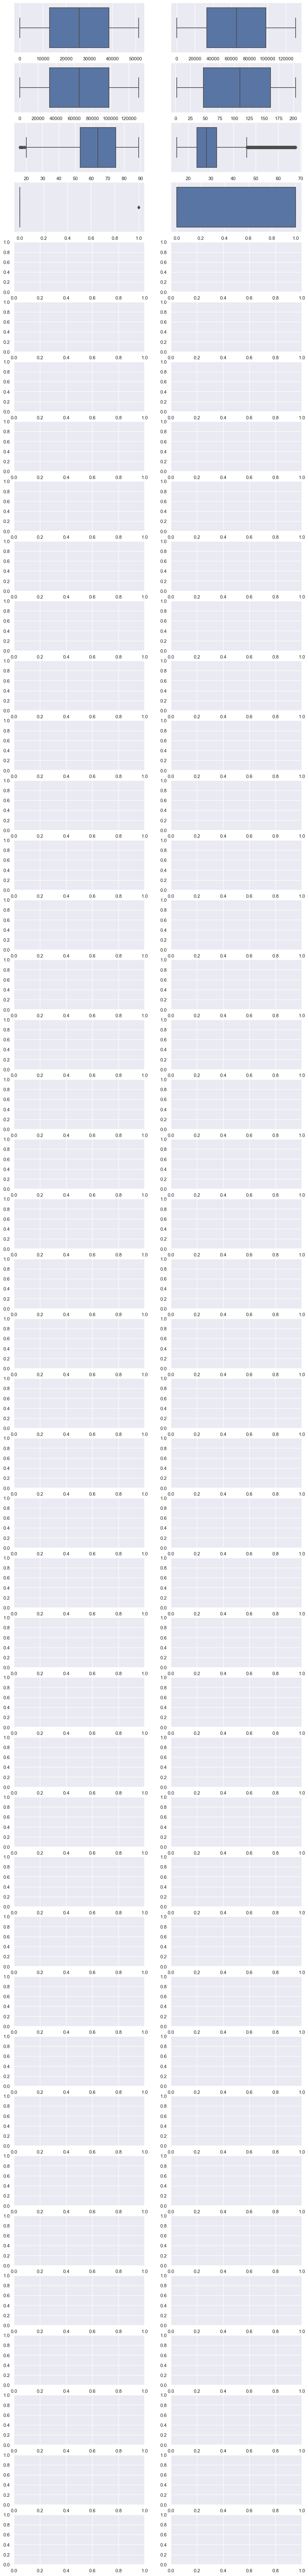

In [10]:
import numpy as np


ncols = 2
nrows = np.ceil(len(train.columns) / ncols).astype(int)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, nrows * 2.5))

for c, ax in zip(train.columns, axs.flatten()):
    # Modify the line below to create boxplots instead of histograms
    sns.boxplot(data=train, x=c, ax=ax)

fig.suptitle('Boxplots of all variables', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


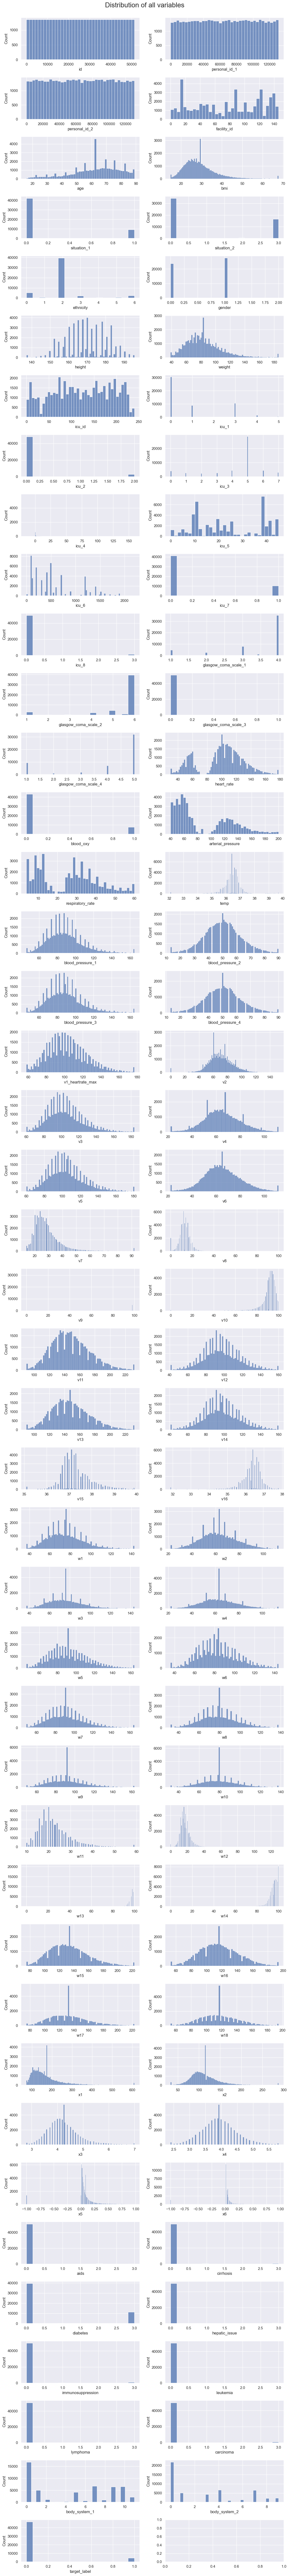

In [ ]:
'''#view data distribution 
ncols = 2
nrows = np.ceil(len(train.columns)/ncols).astype(int)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, nrows*2.5))
for c, ax in zip(train.columns, axs.flatten()):
    sns.histplot(train, x=c, ax=ax)
fig.suptitle('Distribution of all variables', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])'''


In [ ]:
'''# The resulting DataFrame will only contain rows where both "x5" and "x6" are greater than or equal to 0.

train = train[(train["x5"]>=0) & (train["x6"]>=0)]'''


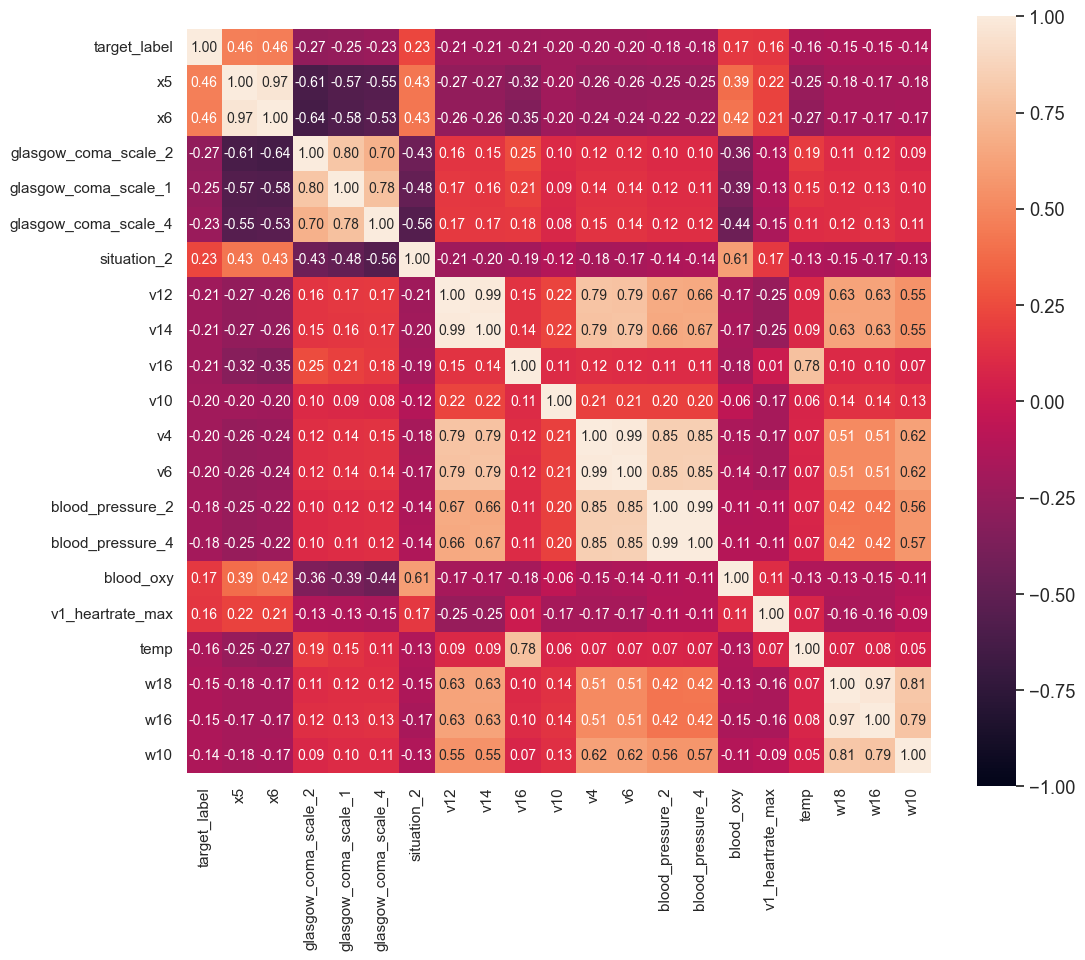

In [ ]:
'''TARGET = "target_label"
k = 21  # number of variables for heatmap
corrmat = train.corr()
corrmat = np.abs(corrmat)
cols = corrmat.nlargest(k, TARGET)[TARGET].index
cm = np.corrcoef(train[cols].values.T)

fig, ax = plt.subplots(figsize=(12, 10))
sns.set(font_scale=1.2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={
                 "size": 10}, yticklabels=cols.values, xticklabels=cols.values, vmin=-1, vmax=1)
plt.show()'''


In [ ]:
#dimentionality reduction PCA
